In [1]:
%%capture
!pip install numpy pandas statmodels scipy

In [2]:
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
import pandas as pd

from random import choices
from scipy import stats
from statsmodels.api import OLS
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt

# Metalearners Estimators

By Niccolò Rocchi, Alessio Zanga and Fabio Stella.

## Abstract

The focus on this notebook will be on the **CATE estimation**.

The CATE (Conditional Average Treatment Effect) generalizes the ATE. We are in the setting of binary treatment $W\in\{0,1\}$, with response variable $Y$ and some covariates $\mathbf{X}=\{X_1, X_2, \cdots, X_n\}$.

Recall the CATE definition:
$$
\tau(\textbf{x}):=\mathbb{E}\left[Y(1)-Y(0)|\mathbf{X}=\mathbf{x}\right]
$$

If $\mathbf{X}$ consists of all observed covariates, we talk about **IATE** (Individualized Average Treatment Effect). In the current notebook we are concerned about CATE estimation, thus we assume from now that the set $\mathbf{X}$ also contains a **sufficient adjustment set**, that is we already achieved the **identification** of the effect.

**Metalearners** are binary treatment CATE estimators. The name *metalearners* stems from being agnostic with respect to the specific model(s) that is used inside them for regression purposes. They differ among each other in the way they exploit data and account for the heterogeneous propensity score of being treated: $P(W=1|\mathbf{X})$.

The methods presented here are:

1. **S-learner**: for COM estimation
2. **T-learner**: for GCOM estimation
3. **X-learner**: improved version of GCOM

The methods will be implemented and evaluated on synthetic data, in both their accuracy and bias variance. Some parts of code are taken from the [EconML](https://github.com/py-why/EconML) example notebooks.

## Data

We use the data generating process from [Kunzel et al.](https://arxiv.org/abs/1706.03461). The outcome $Y$ is generated as a function of the treatment $W$ and $d$ covariates $\mathbf{X}$ by means of the following equation:

$$
Y = \mu_1(\mathbf{x}) \cdot W + \mu_0(\mathbf{x}) \cdot (1-W) + \epsilon
$$

where:
* $\mathbf{X} \sim N(0, \mathbf{\Sigma})$, $~W \sim Bern(e(\mathbf{x}))$ are the distributions of the observed variables
* $e(\mathbf{x}) = P(W=1|\mathbf{X}=\mathbf{x})$ is the propensity score
* $\mu_0(\mathbf{x}) = \mathbf{x}^T\beta$ with $\beta\sim Unif([-3, 3]^d)$
* $\mu_1(\mathbf{x}) = \mu_0(\mathbf{x}) + 8\cdot\mathbf{I}(x_2>0.1)$



The CATE definition is the same as depicted above. With this data generation mechanism, it ends up that the true CATE is:
$$
\mathbf{\tau}(\mathbf{x}) = 8\cdot\mathbf{I}(x_2>0.1)
$$

We implement the data generation mechanism with a custom propensity score $e(\mathbf{x})$ and $\mathbf{\Sigma}=\mathbf{I}$, the identity matrix.

In [3]:
# Define DGP
def generate_data(n, d):

    """
    Parameters.
        n (int): population size
        d (int): number of covariates
    """

    # Generate covariates
    X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    X_dict = {f"X_{k}":X[:, k] for k in range(X.shape[1])}

    # Define propensity function
    propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)

    # Generate treatment
    T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)

    # Define mu_0
    beta = uniform(-3, 3, d)
    mu_0 = np.apply_along_axis(lambda x: np.dot(x, beta), 1, X)

    # Define treatment effect
    treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8

    # Generate outcome Y
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = treat_effect * T + mu_0 + normal(0, 1)

    return pd.DataFrame({"y": Y, "w": T, **X_dict, "CATE": treat_effect})

In [4]:
# Generate train and test data
d = 5
n = 1000

data = generate_data(n, d)
train_data = data.sample(frac=0.8,random_state = 42)
test_data = data.drop(train_data.index).sort_values(by = "X_1")

train_y, train_w, train_X, train_true_cate = train_data["y"], train_data["w"], train_data.iloc[:, 2:-1], train_data.iloc[:, -1]
test_y, test_w, test_X, test_true_cate = test_data["y"], test_data["w"], test_data.iloc[:, 2:-1], test_data.iloc[:, -1]

In [5]:
train_data.head()

,y,w,X_0,X_1,X_2,X_3,X_4,CATE
521,3.826211,1,0.653345,-1.619501,-0.463704,0.238187,0.295166,0
737,-3.889430,0,-1.167332,-1.002809,-1.008116,0.563935,1.172347,0
740,2.187243,1,1.028217,-0.778522,0.325408,-0.044973,1.291936,0
660,0.900877,0,-0.136673,-1.111261,0.785260,-0.977085,-1.143490,0
411,-2.592401,0,1.573622,2.419188,0.779216,-0.042372,0.502547,8


## S-learner, T-learner, X-learner

### Implementation

The following implementations are based on the pseudocode available in [Kunzel et al. (2019), pp.40-41](https://arxiv.org/pdf/1706.03461).

In [6]:
class SLearner:

    def __init__(self, model):
      self.model = model

    def fit(self, X: pd.DataFrame, y: pd.DataFrame, w: pd.DataFrame):
        # Estimator for Y ~ (X, W).
        self.mu = self.model().fit(pd.concat([X, w], axis = 1), y)
        return self

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        w_1 = np.ones((len(X), 1))
        w_0 = np.zeros((len(X), 1))
        # Compute the CATE.
        tau_hat =  self.mu.predict(np.concatenate((X, w_1), axis = 1)) - self.mu.predict(np.concatenate((X, w_0), axis = 1))
        return pd.DataFrame(tau_hat, columns = ["tau"])

In [7]:
class TLearner:

    def __init__(self, model):
      self.model = model

    def fit(self, X: pd.DataFrame, y: pd.DataFrame, w: pd.DataFrame):
        # Compute the subset indicator.
        I0, I1 = (w == 0), (w == 1)
        # Subset the dataset.
        X0, y0, X1, y1 = X[I0], y[I0], X[I1], y[I1]
        # Estimator for Y0 ~ X0.
        self.mu_0 = self.model().fit(X0, y0)
        # Estimator for Y1 ~ X1.
        self.mu_1 = self.model().fit(X1, y1)

        return self

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        # Compute the CATE.
        tau_hat =  self.mu_1.predict(X) - self.mu_0.predict(X)

        return pd.DataFrame(tau_hat, columns = ["tau"])

In [8]:
class XLearner:

    def __init__(self, model, propensity_model):
      self.model = model
      self.propensity_model = propensity_model

    def fit(self, X: pd.DataFrame, y: pd.DataFrame, w: pd.DataFrame):
        # Fit the propensity score estimator.
        self.g = self.propensity_model().fit(X, w)

        # Compute the subset indicator.
        I0, I1 = (w == 0), (w == 1)
        # Subset the dataset.
        X0, y0, X1, y1 = X[I0], y[I0], X[I1], y[I1]
        # Estimator for Y0 ~ X0.
        self.mu_0 = self.model().fit(X0, y0)
        # Estimator for Y1 ~ X1.
        self.mu_1 = self.model().fit(X1, y1)
        # Compute the treatment effects.
        D0 = self.mu_1.predict(X0) - y0
        D1 = y1 - self.mu_0.predict(X1)
        # Estimate CATE in two ways.
        self.tau_0 = self.model().fit(X0, D0)
        self.tau_1 = self.model().fit(X1, D1)

        return self

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        # Estimate the propensity score.
        g_hat = self.g.predict(X)

        # Average the estimates.
        tau_hat =  g_hat * self.tau_0.predict(X) + (1 - g_hat) * self.tau_1.predict(X)

        return pd.DataFrame(tau_hat, columns = ["tau"])

### Evaluation

We set a **model** for regressing $Y$ and a model for the propensity score. Notice that, by using a model for $e(\mathbf{x})$ in the X-learner, we are estimating the CATE in a **doubly-robust** fashion, as indeed suggested by Kunzel et al.

In [9]:
# Choose models
model = GradientBoostingRegressor
propensity_model = RandomForestRegressor

train_true_cate = train_data["CATE"]
test_true_cate = test_data["CATE"]

In [10]:
# Fit a new S-Learner estimator.
s_learner = SLearner(model).fit(train_X, train_y, train_w)

In [11]:
# Estimate CATE over the train set.
train_pred_cate_s = s_learner.predict(train_X)
# Estimate CATE over the test set.
test_pred_cate_s = s_learner.predict(test_X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [12]:
# Fit a new T-Learner estimator.
t_learner = TLearner(model).fit(train_X, train_y, train_w)

In [13]:
# Estimate CATE over the train set.
train_pred_cate_t = t_learner.predict(train_X)
# Estimate CATE over the test set.
test_pred_cate_t = t_learner.predict(test_X)

In [14]:
# Fit a new X-Learner estimator.
x_learner = XLearner(model, propensity_model).fit(train_X, train_y, train_w)

In [15]:
# Estimate CATE over the train set.
train_pred_cate_x = x_learner.predict(train_X)
# Estimate CATE over the test set.
test_pred_cate_x = x_learner.predict(test_X)

We compare these three metalearners in their point-wise accuracy and bias variance.

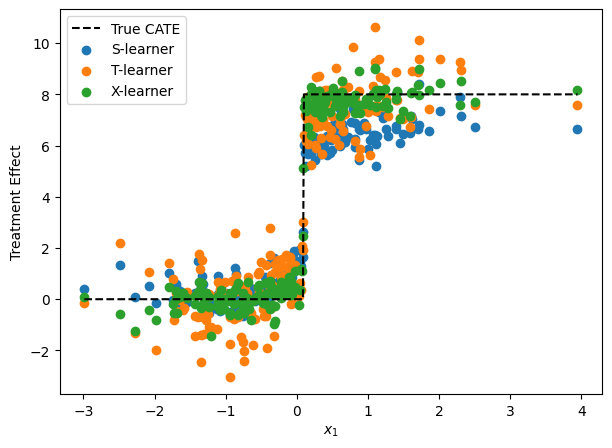

In [16]:
plt.figure(figsize=(7, 5))
plt.plot(test_X.iloc[:, 1], test_true_cate, color='black', ls='--', label='True CATE')
plt.scatter(test_X.iloc[:, 1], test_pred_cate_s, label="S-learner")
plt.scatter(test_X.iloc[:, 1], test_pred_cate_t, label="T-learner")
plt.scatter(test_X.iloc[:, 1], test_pred_cate_x, label="X-learner")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

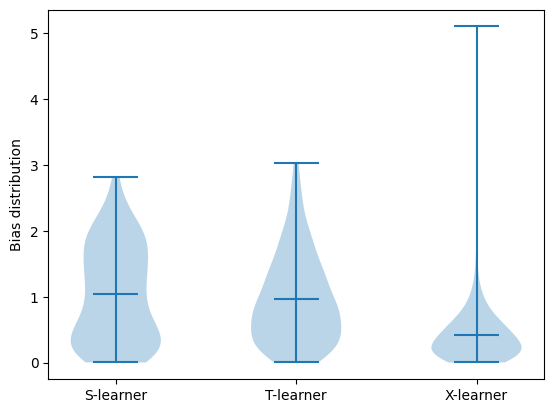

In [17]:
# Visualization of bias distribution
plt.violinplot([np.abs(test_pred_cate_s.values[:,0] - test_true_cate),
                np.abs(test_pred_cate_t.values[:,0] - test_true_cate),
                np.abs(test_pred_cate_x.values[:,0] - test_true_cate)],
               showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3], ['S-learner', 'T-learner', 'X-learner'])
plt.show()

### Confidence intervals

Following Kunzel et al., we may also want to give the estimate a confidence interval. This is performed in a bootstrapping fashion. We choose to compute the interval for the first test set record, using the Xlearning procedure.

In [18]:
def compute_ci(
    X: pd.DataFrame,
    y: pd.DataFrame,
    w: pd.DataFrame,
    p: pd.DataFrame,
    B: int,
    alpha: float
):
    # Get indices stratified on treatment.
    S0, S1 = w.index[w == 0].tolist(), w.index[w == 1].tolist()
    # Get numbers of samples per strata.
    n0, n1 = len(S0), len(S1)
    # List of bootstrap estimates.
    tau_hat_b = []
    # Perform the bootstrap.
    for b in range(B):
        # Resample dataset with replacement.
        s_b = choices(S0, k = n0) + choices(S1, k = n1)
        X_b, y_b, w_b = X.loc[s_b, :], y.loc[s_b], w.loc[s_b]
        # Fit the estimator on the bootstrap.
        tau_hat_b.append(XLearner(model, propensity_model).fit(X_b, y_b, w_b).predict(p))
    # Fit the estimator on the data set.
    tau_hat = XLearner(model, propensity_model).fit(X, y, w).predict(p)
    # Compute the standard deviation of the boostrap estimates.
    sigma = np.std(pd.concat(tau_hat_b))
    # Compute the confidence interval with the given signficance level alpha.
    lower, upper = stats.norm.interval(1 - alpha, loc = tau_hat, scale = sigma)

    return (float(tau_hat.to_numpy()), (float(lower), float(upper)))

In [19]:
%%time
compute_ci(
    X = train_X,
    y = train_y,
    w = train_w,
    p = test_data.iloc[[0], 2:-1],
    B = 100,
    alpha = 0.05
)

CPU times: user 1min 30s, sys: 267 ms, total: 1min 30s
Wall time: 1min 43s


(0.09625859587612681, (-0.983569849626581, 1.1760870413788347))

## Additional material

The [EconML](https://github.com/py-why/EconML) package provides the same, plus others, pre-built metalearners, such as the DomainAdaptation-Learner.

1. [Here](https://github.com/py-why/EconML/blob/main/notebooks/Metalearners%20Examples.ipynb) you can find a comprehensive notebook on how to use them and compare the predictions
2. Another useful notebook, to be kept as a reference, is the one regarding [Double Machine Learning](https://github.com/py-why/EconML/blob/main/notebooks/Double%20Machine%20Learning%20Examples.ipynb) algorithms.